In [38]:
import torch
from PIL import Image
import clip
import matplotlib.pyplot as plt
import numpy as np

In [39]:
# Устройство для выполнения вычислений
device = "cuda" if torch.cuda.is_available() else "cpu"

In [40]:
# Загружаем модель CLIP
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [41]:
# Получаем доступ к самой модели (без трансформаторов)
initial_model = model
# Сохраняем начальные веса модели
initial_weights = initial_model.state_dict()

In [42]:
# Загрузим новые веса
new_model = clip.load("ViT-B/32", device=device)[0]
new_model.load_state_dict(torch.load("clip.pt", map_location=device))
loaded_weights = new_model.state_dict()

In [43]:
# Функция для подсчета измененных слоев
def count_changed_layers(weights_before, weights_after, tolerance=1e-6):
    changed_layers_count = 0
    total_layers = len(weights_before)
    
    for key in weights_before:
        if not torch.allclose(weights_before[key], weights_after[key], atol=tolerance):
            print(f"Weights for layer {key} have changed.")
            changed_layers_count += 1
            
            # Опционально: вывод максимума разницы
            diff = torch.abs(weights_before[key] - weights_after[key])
            print(f"Max difference: {diff.max().item():.7f}")
    
    return changed_layers_count, total_layers

In [44]:
# Проверка и счетчик измененных слоев
changed_layers_count, total_layers = count_changed_layers(initial_weights, loaded_weights)

Weights for layer positional_embedding have changed.
Max difference: 0.0000665
Weights for layer text_projection have changed.
Max difference: 0.0001287
Weights for layer logit_scale have changed.
Max difference: 0.0002065
Weights for layer visual.class_embedding have changed.
Max difference: 0.0000741
Weights for layer visual.positional_embedding have changed.
Max difference: 0.0001000
Weights for layer visual.proj have changed.
Max difference: 0.0001354
Weights for layer visual.conv1.weight have changed.
Max difference: 0.0000916
Weights for layer visual.ln_pre.weight have changed.
Max difference: 0.0001056
Weights for layer visual.ln_pre.bias have changed.
Max difference: 0.0000750
Weights for layer visual.transformer.resblocks.0.attn.in_proj_weight have changed.
Max difference: 0.0000944
Weights for layer visual.transformer.resblocks.0.attn.in_proj_bias have changed.
Max difference: 0.0001221
Weights for layer visual.transformer.resblocks.0.attn.out_proj.weight have changed.
Max di

In [45]:
# Отчет о результате
print(f"\nTotal layers: {total_layers}, Changed layers: {changed_layers_count}")


Total layers: 302, Changed layers: 302


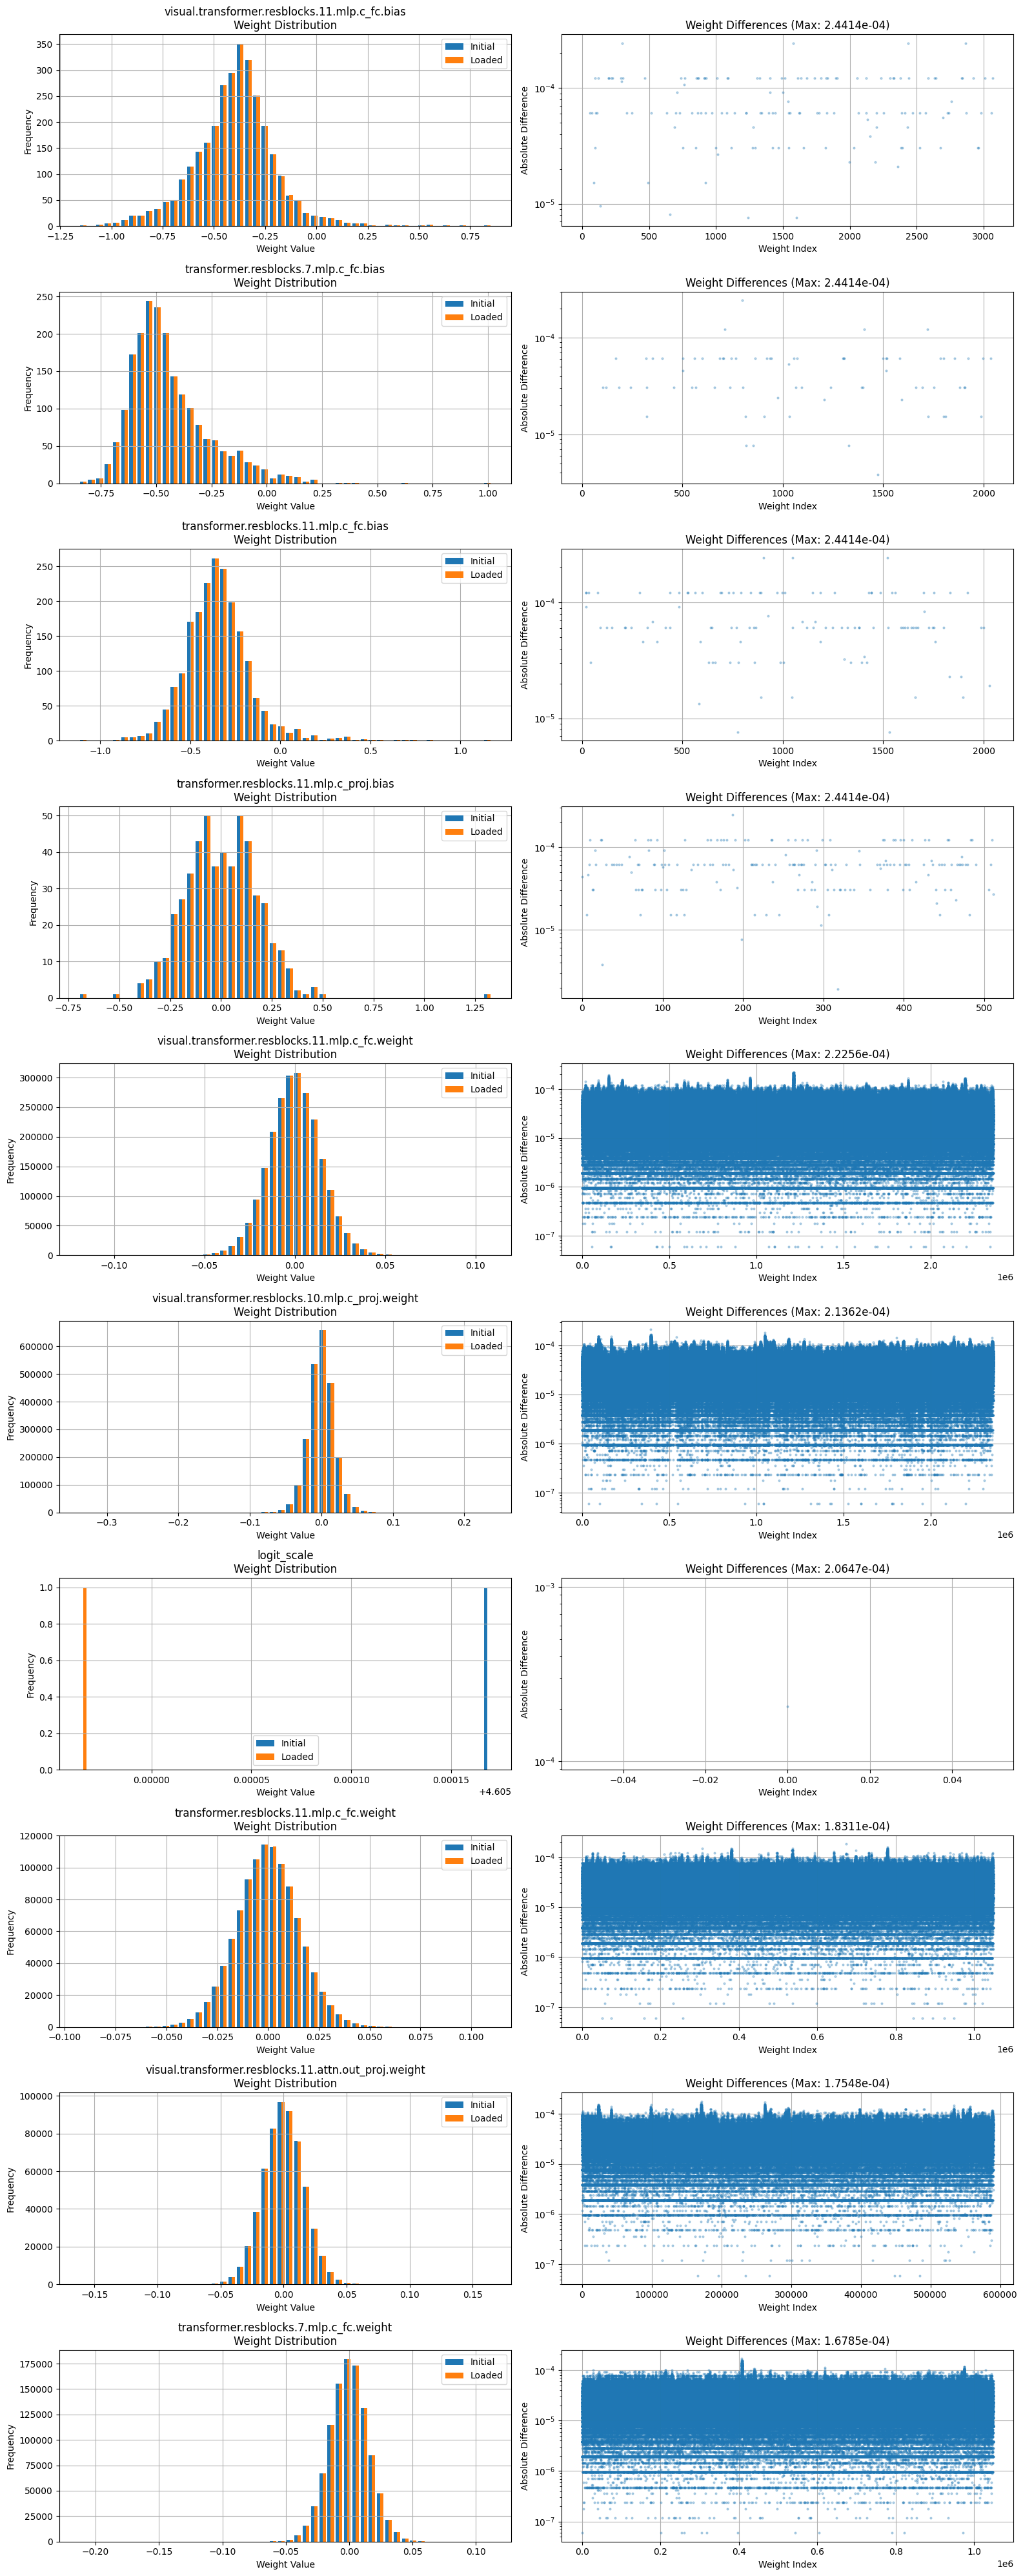

In [46]:
def visualize_weight_differences(weights_before, weights_after, top_n=10):
    # Собираем данные о максимальных изменениях по слоям
    layer_diffs = []
    for key in weights_before:
        diff = torch.abs(weights_before[key] - weights_after[key])
        max_diff = diff.max().item()
        layer_diffs.append((key, max_diff))

    # Сортируем слои по величине изменений
    layer_diffs.sort(key=lambda x: x[1], reverse=True)
    
    # Выбираем топ-N слоев с наибольшими изменениями
    top_layers = layer_diffs[:top_n]
    
    # Создаем фигуру с несколькими подграфиками
    fig, axes = plt.subplots(nrows=top_n, ncols=2, figsize=(16.0, 4.0*top_n))
    plt.subplots_adjust(hspace=0.5)
    
    for i, (key, max_diff) in enumerate(top_layers):
        # Получаем веса до и после
        w_before = weights_before[key].flatten().cpu().numpy()
        w_after = weights_after[key].flatten().cpu().numpy()
        diff = np.abs(w_before - w_after)
        
        # Гистограмма распределения весов
        axes[i,0].hist([w_before, w_after], bins=50, label=['Initial', 'Loaded'])
        axes[i,0].set_title(f'{key}\nWeight Distribution')
        axes[i,0].set_xlabel('Weight Value')
        axes[i,0].set_ylabel('Frequency')
        axes[i,0].grid(True)
        axes[i,0].legend()
        
        # График изменения весов
        axes[i,1].plot(diff, 'o', markersize=2, alpha=0.3)
        axes[i,1].set_title(f'Weight Differences (Max: {max_diff:.4e})')
        axes[i,1].set_xlabel('Weight Index')
        axes[i,1].set_ylabel('Absolute Difference')
        axes[i,1].grid(True)
        axes[i,1].set_yscale('log')  # Логарифмическая шкала для лучшей видимости

    # Save and close
    plt.tight_layout()
    plt.savefig("weight_differences.png", dpi=300, bbox_inches="tight", pad_inches=0.5)
    
    plt.show()

# Пример использования с визуализацией топ-10 измененных слоев
visualize_weight_differences(initial_weights, loaded_weights, top_n=10)